# **Reinforcement Learning Project - Inventory beer game**

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

### **Setup**
For better understanding of the code output decrease supply chain from customer to distributor, set max_iteration to one,<br>
set lead time lag to False (line 25 in main function), activate print functions (main function) and define state- and action-pairs as follows:<br>
- state_pairs = [(i, j) for i in states for j in states]
- action_pairs = [(i, j) for i in actions for j in actions]

In [180]:
# Supply Chain and its agents
supply_chain = {'level 0': 'Customer',
                'level 1': 'Retailer',
                'level 2': 'Distributor',
                'level 3': 'Manufacturer'}

agents = [supply_chain[i] for i in list(supply_chain.keys())[1:]]


# All possible coded inventory positions of agents and the respective state pairs (5 states with 25 state pairs)
states = np.arange(start=1, stop=7)
state_pairs = [(i, j, k) for i in states for j in states for k in states]

# y-value in ordering rule x+y with x equal to the demand from the downstream agent and the respective action pairs (4 actions with 16 action pairs)
actions = np.arange(stop=4)
action_pairs = [(i, j, k) for i in actions for j in actions for k in actions]


# Initial matrix with Q-values (minimization -> high values)
Q_values = np.full(shape=(len(state_pairs), len(action_pairs)), fill_value=10000)
df_Q_values = pd.DataFrame(data=Q_values, index=state_pairs, columns=action_pairs)
display(df_Q_values.head())

,"(0, 0, 0)","(0, 0, 1)","(0, 0, 2)","(0, 0, 3)","(0, 1, 0)","(0, 1, 1)","(0, 1, 2)","(0, 1, 3)","(0, 2, 0)","(0, 2, 1)",...,"(3, 1, 2)","(3, 1, 3)","(3, 2, 0)","(3, 2, 1)","(3, 2, 2)","(3, 2, 3)","(3, 3, 0)","(3, 3, 1)","(3, 3, 2)","(3, 3, 3)"
"(1, 1, 1)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
"(1, 1, 2)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
"(1, 1, 3)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
"(1, 1, 4)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
"(1, 1, 5)",1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


In [181]:
# Define parameters
iteration = 1
max_iteration = 1 #1000000
T = 15 #smaller
gamma = 1 #low: faster convergence! less variance
alpha = 0.17 #high: faster updating q-values (more weight to new observations) and big variance in q-value updates
sigma = 0.005
proba_exploitation = 0.02
start_exploitation = proba_exploitation

# Set up Lists to store the results of each iteration/episode
S = [list(np.repeat(0, len(agents))) for i in range(T+1)]
CS = [list(np.repeat(0, len(agents))) for i in range(T+1)]
D = [list(np.repeat(0, len(agents))) for i in range(T+1)]
O = [list(np.repeat(0, len(agents))) for i in range(T+1)]
x = [list(np.repeat(0, len(agents))) for i in range(T+1)]
y = [list(np.repeat(0, len(agents))) for i in range(T+1)]
r = [list(np.repeat(0, len(agents))) for i in range(T+1)]
R = [0 for i in range(T)]
G = [0 for i in range(T)]
q = [0 for i in range(T)]
Q = [0 for i in range(max_iteration)]

**Meaning of the variables**
- S: (start-)inventory positions/states per agent and time step t
- CS: coded states per agent and time step t
- O: ordering size per agent and time step t
- D: distribution amount per agent and time step t
- x: demand from downstream level per agent and time step t
- y: action per agent and time step t
- r: reward per agent and time step t
- R: reward of the supply chain per time step t
- Return G: total discounted rewards per time step t
- q: measure the decrease of the Q-value per time step t
- Q: measure the mean decrease of Q-values per episode to indicate convergence

In [182]:
# helperfunctions
# function to convert real states to coded states
def coded_state(inventory):
    if inventory < -5:
        return 1
    elif inventory < 0:
        return 2
    elif inventory < 5:
        return 3
    elif inventory < 10:
        return 4
    elif inventory < 15:
        return 5
    else:
        return 6


# function to view episodes
def fun_episode(S, CS, D, O, x, y, r, head=True):
    time_steps = ['t='+str(i) for i in np.arange(start=0, stop=T+1)]

    df = pd.DataFrame({'Inventory/States S': [tuple(i) for i in S],
                   'Coded states CS': [tuple(i) for i in CS],
                   'Demand x': [tuple(i) for i in x],
                   'Distribution amount D': [tuple(i) for i in D],
                   'Action y': [tuple(i) for i in y],
                   'Ordering size': [tuple(i) for i in O],
                   'Costs r': [tuple(i) for i in r]},
                   index=time_steps)
    df.index.name = 'Time'
    if head == True:
        return display(df.head())
    else: return display(df)


# function to define the starting states of the supply chain
def fun_start_state(how='value', inv=10):
    # select own start values for all agents
    if how == 'value':
        for agent in range(len(agents)):
            S[0][agent] = inv
            CS[0][agent] = coded_state(S[0][agent])
    
    # each episode has a change of 50% to start with high (12) or with low (0) inventory for all agents
    elif how == 'high/low':
        starting_state = random.choices(population=['high', 'low'], weights=[0.5, 0.5])[0]
        if starting_state == 'high':
            for agent in range(len(agents)):
                S[0][agent] = 10
                CS[0][agent] = coded_state(S[0][agent])
        else:
            for agent in range(len(agents)):
                S[0][agent] = 1
                CS[0][agent] = coded_state(S[0][agent])

    # random starting positions (-10 to 16) of agents for each episode
    elif how == 'random':
        for agent in range(len(agents)):
            S[0][agent] = random.choices(np.arange(start=-10, stop=16))[0]
            CS[0][agent] = coded_state(S[0][agent])


# function to switch lead time lags on or off
def fun_lead_time(lag):
    if lag == False:
        lag = 0
        print('No lead time lags.')
    else:
        lag = random.choices(population=[0, 1, 2], weights=[0.6, 0.3, 0.1])[0]
        print('Lead time lag of {} time steps\n'.format(lag))
    return lag


# function to measure the Q-value decrease
def fun_q_decrease(alpha, q_value, G):
    new_q_value = (1-alpha) * q_value + alpha * G
    decrease = (q_value - new_q_value) / q_value
    return new_q_value, decrease


# function to visualize the Q-vlaue decrease
def plot_q_decrease(Q, iteration):
    plt.figure(figsize=(12,4))
    plt.plot(Q)
    plt.xlim(0, iteration)
    plt.ylim(0, 1.1)
    plt.xlabel('episode/iteration')
    plt.ylabel('Q-value decrease')
    plt.title('Q-value decrease per episode', size=18)
    return plt.show()

In [183]:
# Three possible options to set starting states
fun_start_state(how='value', inv=10)
print('Inventory state S: {}'.format(S))
print('Coded state S: {}\n'.format(CS))

fun_start_state(how='high/low')
print('Inventory state S: {}'.format(S))
print('Coded state S: {}\n'.format(CS))

fun_start_state(how='random')
print('Inventory state S: {}'.format(S))
print('Coded state S: {}\n'.format(CS))

Inventory state S: [[10, 10, 10], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
Coded state S: [[5, 5, 5], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]

Inventory state S: [[1, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
Coded state S: [[3, 3, 3], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]

Inventory state S: [[10, 6, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
Coded state S: [[5, 4,

iteration 1
-------------------episode 1------------------
Exploitation probability: 0.02

-----------------time step t=0----------------
State S: (1, 1, 1) and coded state CS: (3, 3, 3)
No lead time lags.
------------------Retailer------------------
Demand x from downstream (Customer) at t-1: 0
Distribution size D: 0
Backlog size: 0
Best action y*: 0
Action y: 0
Ordering size O: 0

------------------Distributor------------------
Demand x from downstream (Retailer) at t-1: 0
Distribution size D: 0
Backlog size: 0
Best action y*: 0
Action y: 3
Ordering size O: 3

------------------Manufacturer------------------
Demand x from downstream (Distributor) at t-1: 0
Distribution size D: 0
Backlog size: 0
Best action y*: 0
Action y: 1
Ordering size O: 1

UPDATING STATES AND CALCULATING COSTS PER AGENT
------------------Retailer------------------
Inventory 1 after receiving order +0 of t-1: 1
Costs r: 1

------------------Distributor------------------
Inventory 1 after receiving order +0 of t-1:

,Inventory/States S,Coded states CS,Demand x,Distribution amount D,Action y,Ordering size,Costs r
Time,,,,,,,
t=1,"(1, 1, 1)","(3, 3, 3)","(0, 0, 0)","(0, 0, 0)","(0, 3, 1)","(0, 3, 1)","(1, 1, 1)"
t=2,"(1, 1, 1)","(3, 3, 3)","(2, 0, 3)","(1, 0, 1)","(0, 0, 0)","(2, 0, 3)","(2, 2, 4)"
t=3,"(-1, 2, -1)","(2, 3, 2)","(1, 2, 1)","(0, 2, 1)","(0, 0, 0)","(0, 2, 0)","(3, 1, 2)"
t=4,"(1, 1, 2)","(3, 3, 3)","(12, 0, 2)","(2, 0, 2)","(3, 2, 1)","(15, 2, 3)","(20, 3, 0)"
t=5,"(-11, 3, 0)","(1, 3, 3)","(11, 15, 2)","(0, 3, 2)","(1, 0, 0)","(1, 15, 2)","(22, 24, 1)"
t=6,"(-8, -10, 1)","(1, 1, 3)","(22, 11, 15)","(3, 2, 2)","(2, 1, 3)","(16, 2, 18)","(38, 18, 26)"
t=7,"(-20, -9, -12)","(1, 1, 1)","(21, 25, 14)","(2, 2, 14)","(1, 1, 0)","(2, 17, 2)","(38, 46, 4)"
t=8,"(-19, -11, 4)","(1, 1, 3)","(26, 13, 17)","(2, 13, 4)","(3, 3, 1)","(10, 5, 18)","(48, 0, 26)"
t=9,"(-13, -9, -11)","(1, 1, 1)","(13, 19, 16)","(13, 4, 16)","(0, 3, 0)","(0, 13, 5)","(0, 30, 2)"


-----Rewards and Total discounted returns-----
Immediate reward R in t=14: 30
Immediate reward R in t=13: 29
Immediate reward R in t=12: 41
Immediate reward R in t=11: 46
Immediate reward R in t=10: 55
Immediate reward R in t=9: 38
Immediate reward R in t=8: 32
Immediate reward R in t=7: 74
Immediate reward R in t=6: 88
Immediate reward R in t=5: 82
Immediate reward R in t=4: 47
Immediate reward R in t=3: 23
Immediate reward R in t=2: 6
Immediate reward R in t=1: 8
Immediate reward R in t=0: 3

Total discounted rewards (Return G): 
[602, 599, 591, 585, 562, 515, 433, 345, 271, 239, 201, 146, 100, 59, 30.0]

---------------UPDATING Q-VALUES--------------
t=0: state: (3, 3, 3), action: (0, 3, 1), old Q-value: 1000, return: 602
New Q-value: 932.34

t=1: state: (3, 3, 3), action: (0, 0, 0), old Q-value: 1000, return: 599
New Q-value: 931.83

t=2: state: (2, 3, 2), action: (0, 0, 0), old Q-value: 1000.0, return: 591
New Q-value: 930.47

t=3: state: (3, 3, 3), action: (3, 2, 1), old Q-value:

,"(0, 0, 0)","(0, 0, 1)","(0, 0, 2)","(0, 0, 3)","(0, 1, 0)","(0, 1, 1)","(0, 1, 2)","(0, 1, 3)","(0, 2, 0)","(0, 2, 1)",...,"(3, 1, 2)","(3, 1, 3)","(3, 2, 0)","(3, 2, 1)","(3, 2, 2)","(3, 2, 3)","(3, 3, 0)","(3, 3, 1)","(3, 3, 2)","(3, 3, 3)"
"(1, 1, 1)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(1, 1, 2)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(1, 1, 3)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,888.65,1000,1000
"(1, 1, 4)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(1, 1, 5)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(6, 6, 2)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(6, 6, 3)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(6, 6, 4)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(6, 6, 5)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000


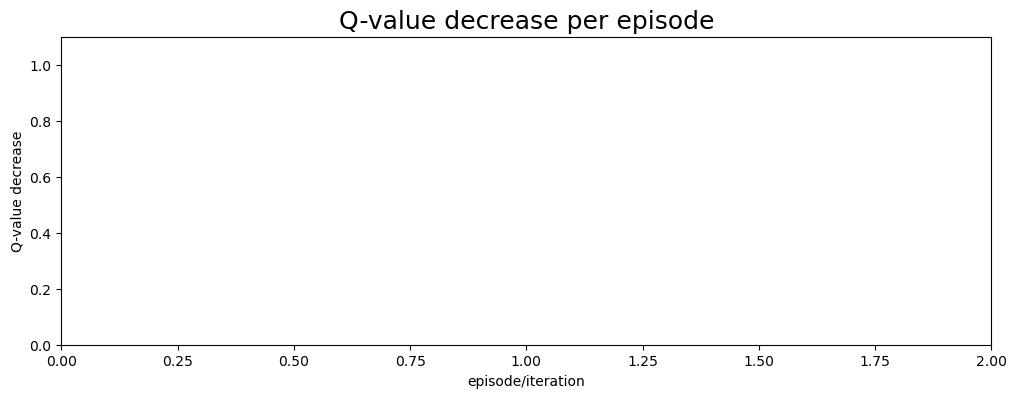

In [184]:
#%%capture
# Main function

while iteration <= max_iteration:
    if iteration in [1, 10, 100, 1000, 10000, 25000, 50000, 75000,
                    100000, 250000, 500000, 750000, max_iteration]:
         print('iteration {}'.format(iteration))

    print('-------------------episode {}------------------'.format(iteration))
    print('Exploitation probability: {}\n'.format(proba_exploitation))
    t=0

    # random starting position of agents for each episode
    fun_start_state(how='high/low', inv=-2) #option 1: ('value', inv=12); option 2: 'high/low'; option 3: 'random'

    while t < T:
        print('-----------------time step t={}----------------'.format(t))

        # view state and coded state
        state = tuple(S[t])
        c_state = tuple(CS[t])
        print('State S: {} and coded state CS: {}'.format(state, c_state))

        # define random lead time lag (between 0 and 2)        
        lead_time_lag = fun_lead_time(lag=False)

        for agent in range(len(agents)):
            level = supply_chain['level ' + str(agent+1)]
            print('------------------{}------------------'.format(level))

        # step 1: receive the new demand of the downstream agent
            if level == 'Retailer':
                x[t][agent] = np.random.randint(low=0, high=15)
            else:
                x[t][agent] = O[t-1][agent-1]
            
            # Add negative inventory (=demand of previous time steps) to the new demand
            inventory = S[t][agent]
            if inventory >= 0:
                print('Demand x from downstream ({}) at t-1: {}'.format(supply_chain['level ' + str(agent)], x[t][agent]))
                pass
            else:
                print('Demand x from downstream ({}) at t-1 + demand of previous time steps:'.format(supply_chain['level ' + str(agent)]))
                print(    '{} + {} = {}'.format(x[t][agent], np.abs(inventory), x[t][agent] + np.abs(inventory)))
                x[t][agent] += np.abs(inventory)

        # step 2: fulfill order of downstream agent from onhand inventory and calculate possible backlog costs
            # set lead time lags for all agents except retailer (lead time to customer is zero)
            if (level == agents[1]): lag = 0
            else: lag = lead_time_lag

            if (inventory >= 0) & (level != agents[-1]):
                D[t][agent] = min(x[t][agent], max(inventory, D[t-1][agent+1])) #distribution quantity is the demand or the maximum of inventory and last received order
                print('Distribution size D: {}'.format(D[t][agent]))
            elif level != agents[-1]:
                D[t][agent] = min(x[t][agent], D[t-1][agent+1]) #negative inventory is demand of previous time steps and still needs to be complied
                print('Distribution size D (delivery of upstream agent in t-1): {}'.format(D[t][agent])) #(max of demand and last received order)
            elif (inventory >= 0) & (level == agents[-1]):
                D[t][agent] = min(x[t][agent], max(inventory, O[t-1][agent])) #last agent receives his own order out of warehouse
                print('Distribution size D: {}'.format(D[t][agent]))
            else:
                D[t][agent] = min(x[t][agent], O[t-1][agent])
                print('Distribution size D (delivery of warehouse): {}'.format(D[t][agent]))
                
            backlog = x[t][agent] - D[t][agent] #penalty/backlog costs (previous backlogs included in demand if inventory is negative)
            print('Backlog size: {}'.format(backlog))

        # step 3: placing order for stock replenishment
            # define best action for agent and select it with initially very small probability (first exploration and mostly random choices)
            best_action = df_Q_values.iloc[df_Q_values.index.get_loc(tuple(CS[t]))].idxmin()[agent]
            print('Best action y*: {}'.format(best_action))

            y[t][agent] = random.choices([best_action] + list(actions), weights=[proba_exploitation] + list(np.repeat((1 - proba_exploitation) / len(actions), len(actions))))[0]
            print('Action y: {}'.format(y[t][agent]))

            if inventory >= 0:
                O[t][agent] = x[t][agent] + y[t][agent]
            else: O[t][agent] = x[t][agent] + inventory + y[t][agent] #subtract negative inventory (demand of previous time steps) again - has been ordered already
            print('Ordering size O: {}\n'.format(O[t][agent]))

        # step 4: previous orders are received from the upstream agent (update states for t+1)
        print('UPDATING STATES AND CALCULATING COSTS PER AGENT')
        for agent in range(len(agents)):
            level = supply_chain['level ' + str(agent+1)]
            print('------------------{}------------------'.format(level))

            # update inventory with demand of t
            if  S[t][agent] >= 0:
                inventory =  S[t][agent] - x[t][agent]
            else: inventory = - x[t][agent] #demand x contains negative inventory + new demand = new inventory

            # update state t+1 with inventory + received order
            if level != agents[-1]:
                S[t+1][agent] = inventory + D[t][agent+1]
                print('Inventory {} after receiving order +{} of t-1: {}'.format(inventory, D[t][agent+1], S[t+1][agent]))

            # for last agent in supply chain: update state t+1 with inventory + order of t-1 (delivers from warehouse)
            else:
                S[t+1][agent] = inventory + O[t-1][agent]
                print('Inventory {} receiving order +{} of t-1: {}'.format(inventory, O[t-1][agent], S[t+1][agent]))
            
            # update coded states
            CS[t+1][agent] = coded_state(S[t+1][agent])

            # calculate agent's costs (onhand inventory holding costs + penalty costs)
            r[t][agent] = 1 * max(S[t+1][agent], 0) + 2 * (x[t][agent] - D[t][agent]) #backlog
            print('Costs r: {}\n'.format(r[t][agent]))

        # calculate the total supply chain costs in t
        action = tuple(y[t])
        R[t] = np.sum(r[t])
        print('Supply Chain costs R in state {} with action {} at t={}: {}'.format(state, action, t, R[t]))            
        
        # increase time step t
        t += 1
        print('\n\n')

    # view last episode
    fun_episode(S, CS, D, O, x, y, r, head=False)

    # Loop from T to t=0 to calculate immediate rewards and returns
    print('-----Rewards and Total discounted returns-----')
    for t in np.arange(start=0, stop=T)[::-1]:
        # view immediate reward of each visited state-action-pair
        print('Immediate reward R in t={}: {}'.format(t, R[t]))

        # calculate the return G: total discounted rewards
        G[t] = R[t] + np.sum(R[t+1:] * np.array([gamma**i for i in np.arange(start=1, stop=T-t)]))
    
    # view returns of all state-action-pairs
    print('\nTotal discounted rewards (Return G): \n{}\n'.format(G))

    # update all visited Q-values
    print('---------------UPDATING Q-VALUES--------------')
    for t in range(T):
        state = tuple(CS[t])
        action = tuple(y[t])

        # get current Q-value
        q_value = df_Q_values.iloc[df_Q_values.index.get_loc(state), df_Q_values.columns.get_loc(action)]
        print('t={}: state: {}, action: {}, old Q-value: {}, return: {}'.format(t, state, action, q_value, G[t]))

        # update Q-values according to equation 12 in the paper (slide 30 TD-learning script)
        df_Q_values.iloc[df_Q_values.index.get_loc(state), df_Q_values.columns.get_loc(action)] = (1-alpha) * q_value + alpha * G[t] #equal to: q_value + alpha * (G[t] - q_value)
        new_q_value, decrease = fun_q_decrease(alpha, q_value, G[t])
        q[t] = decrease
        print('New Q-value: {}\n'.format(new_q_value))

    # calculate mean Q-value decrease of current episode
    Q[iteration-1] = np.mean(q)
    print('Mean Q-value decrease of all visited state-action-pairs in this episode: {}'.format(Q[iteration-1]))

    # Check if the convergence criterion has been reached
    if (iteration > 100) & (np.mean(np.abs(Q[iteration-5:iteration])) < sigma):
        print('Convergence!')
        break

    # increase exploitation probability linearly
    proba_exploitation += (0.95 - start_exploitation) / max_iteration
    print('\n\n')

    # start with next iteration
    iteration += 1

# round dataframe with Q-values
df_Q_values = np.round(df_Q_values, 2)

# view new Q-value table
display(df_Q_values)

# plot decrease of Q-vlaues
plot_q_decrease(Q, iteration)

### **View new Q-values**

Number of state-action-pairs: 13824
Percentage of updated Q-values: 0.1085 %

Number of visits with max_iteration=1 and T=15: 15
Average amount of visits per state-action-pair: 0.0010850694444444445

Last five Q-value decreases: [0.1102]
Mean of last five Q-value decreases: 0.1102


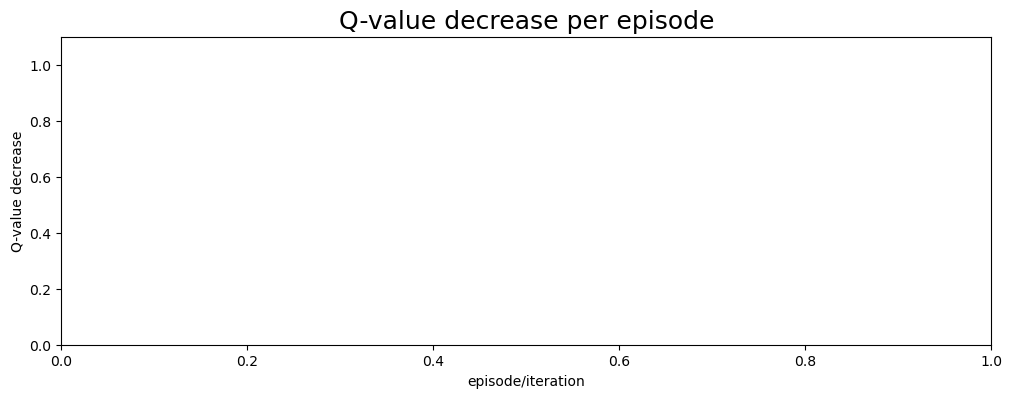

,"(0, 0, 0)","(0, 0, 1)","(0, 0, 2)","(0, 0, 3)","(0, 1, 0)","(0, 1, 1)","(0, 1, 2)","(0, 1, 3)","(0, 2, 0)","(0, 2, 1)",...,"(3, 1, 2)","(3, 1, 3)","(3, 2, 0)","(3, 2, 1)","(3, 2, 2)","(3, 2, 3)","(3, 3, 0)","(3, 3, 1)","(3, 3, 2)","(3, 3, 3)"
"(1, 1, 1)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(1, 1, 2)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(1, 1, 3)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,888.65,1000,1000
"(1, 1, 4)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(1, 1, 5)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(6, 6, 2)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(6, 6, 3)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(6, 6, 4)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000
"(6, 6, 5)",1000.0,1000,1000,1000,1000.0,1000,1000,1000,1000.0,1000,...,1000,1000,1000,1000.0,1000,1000,1000,1000.00,1000,1000


In [185]:
# Percentage of updated Q-values
num_pairs = len(df_Q_values.index) * len(df_Q_values.columns)
print('Number of state-action-pairs: {}'.format(num_pairs))
print('Percentage of updated Q-values: {} %\n'.format(np.round(np.sum(np.sum(df_Q_values != 1000)) / num_pairs * 100, 4)))

visits = max_iteration * T
print('Number of visits with max_iteration={} and T={}: {}'.format(max_iteration, T, visits))
print('Average amount of visits per state-action-pair: {}\n'.format(visits / num_pairs))

# plot decrease of Q-vlaues
iteration = max_iteration
print('Last five Q-value decreases: {}'.format(np.round(Q[iteration-5:iteration], 4)))
print('Mean of last five Q-value decreases: {}'.format(np.round(np.mean(Q[iteration-5:iteration]), 4)))

plot_q_decrease(Q, iteration)

df_Q_values

In [186]:
sys.exit()

SystemExit: 

C:\Users\Dennis\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### **Test performance of the Reinforcement learning ordering mechanism (RLOM) on main and test problems**

In [ ]:
# Main test problem
main_set = {'customer_demand': [15,10,8,14,9,3,13,2,13,11,3,4,6,11,15,12,15,4,12,3,13,10,15,15,3,11,1,13,10,10,0,0,8,0,14],
            'lead_times': [2,0,2,4,4,4,0,2,4,1,1,0,0,1,1,0,1,1,2,1,1,1,4,2,2,1,4,3,4,1,4,0,3,3,4]}

# Test problem 1
set1 = {'customer_demand': [5,14,14,13,2,9,5,9,14,14,12,7,5,1,13,3,12,4,0,15,11,10,6,0,6,6,5,11,8,4,4,12,13,8,12],
        'lead_times': [2,0,2,4,4,4,0,2,4,1,1,0,0,1,1,0,1,1,2,1,1,1,4,2,2,1,4,3,4,1,4,0,3,3,4]}

# Test problem 2
set2 = {'customer_demand': [15,10,8,14,9,3,13,2,13,11,3,4,6,11,15,12,15,4,12,3,13,10,15,15,3,11,1,13,10,10,0,0,8,0,14],
        'lead_times': [[4,2,2,0,2,2,1,1,3,0,0,3,3,3,4,1,1,1,3,0,4,2,3,4,1,3,3,3,0,3,4,3,3,0,3]]}

# Test problem 3
set3 = {'customer_demand': [13,13,12,10,14,13,13,10,2,12,11,9,11,3,7,6,12,12,3,10,3,9,4,15,12,7,15,5,1,15,11,9,14,0,4],
        'lead_times': [4,2,2,0,2,2,1,1,3,0,0,3,3,3,4,1,1,1,3,0,4,2,3,4,1,3,3,3,0,3,4,3,3,0,3]}

# Own test problem
set4 = {'customer_demand': list(np.random.randint(low=0, high=15, size=35)),
        'lead_times': list(np.random.randint(low=0, high=4, size=35))}

In [ ]:
def main_function(t=0, T, problem_set, policy):
    # set starting position of agents
    fun_start_state(how='value', inv=10)



    ####
    lag = problem_set['lead_times'][t]
    if level == agents[0]:
        x[t][agent] = problem_set['customer_demand'][t]
    ####




    if policy == 'optimum':
        y[t][agent] = opt_policy[tuple(CS[t])][agent]
    elif policy == 'zero':
        y[t][agent] = 0
    else: y[t][agent] = np.random.randint(4)



    
    ####
    # View results
    print(R)
    print(np.sum(R))

In [ ]:
# Set up Lists to store the results of each iteration/episode
S = [list(np.repeat(0, len(agents))) for i in range(T+1)]
CS = [list(np.repeat(0, len(agents))) for i in range(T+1)]
D = [list(np.repeat(0, len(agents))) for i in range(T+1)]
O = [list(np.repeat(0, len(agents))) for i in range(T+1)]
x = [list(np.repeat(0, len(agents))) for i in range(T+1)]
y = [list(np.repeat(0, len(agents))) for i in range(T+1)]
r = [list(np.repeat(0, len(agents))) for i in range(T+1)]
R = [0 for i in range(T)]

# Extract optimal policy of Q-values
opt_policy = df_Q_values.idxmin(axis=1)

In [ ]:
#%%capture

main_function(t=0, T=35, problem_set=main_set, policy='optimum')
# main_function(t=0, T=35, problem_set=set1, policy='optimum')
# main_function(t=0, T=35, problem_set=set2, policy='optimum')
# main_function(t=0, T=35, problem_set=set3, policy='optimum')
# main_function(t=0, T=35, problem_set=set4, policy='optimum')

### **Benchmark policy 1: Order = demand (y=0)**

In [ ]:
# Set up Lists to store the results of each iteration/episode
S = [list(np.repeat(0, len(agents))) for i in range(T+1)]
CS = [list(np.repeat(0, len(agents))) for i in range(T+1)]
D = [list(np.repeat(0, len(agents))) for i in range(T+1)]
O = [list(np.repeat(0, len(agents))) for i in range(T+1)]
x = [list(np.repeat(0, len(agents))) for i in range(T+1)]
y = [list(np.repeat(0, len(agents))) for i in range(T+1)]
r = [list(np.repeat(0, len(agents))) for i in range(T+1)]
R = [0 for i in range(T)]

In [ ]:
#%%capture

main_function(t=0, T=35, problem_set=set1, policy='zero')
# main_function(t=0, T=35, problem_set=set1, policy='zero')
# main_function(t=0, T=35, problem_set=set2, policy='zero')
# main_function(t=0, T=35, problem_set=set3, policy='zero')
# main_function(t=0, T=35, problem_set=set4, policy='zero')

### **Benchmark policy 2: Order = demand + random y ∈ [0, 3]**

In [ ]:
# Set up Lists to store the results of each iteration/episode
S = [list(np.repeat(0, len(agents))) for i in range(T+1)]
CS = [list(np.repeat(0, len(agents))) for i in range(T+1)]
D = [list(np.repeat(0, len(agents))) for i in range(T+1)]
O = [list(np.repeat(0, len(agents))) for i in range(T+1)]
x = [list(np.repeat(0, len(agents))) for i in range(T+1)]
y = [list(np.repeat(0, len(agents))) for i in range(T+1)]
r = [list(np.repeat(0, len(agents))) for i in range(T+1)]
R = [0 for i in range(T)]

In [ ]:
#%%capture

main_function(t=0, T=35, problem_set=set1, policy='random')
# main_function(t=0, T=35, problem_set=set1, policy='random')
# main_function(t=0, T=35, problem_set=set2, policy='random')
# main_function(t=0, T=35, problem_set=set3, policy='random')
# main_function(t=0, T=35, problem_set=set4, policy='random')